# Introduction

In this analysis, I will perform text classification on the in-game chat data in Dota 2 matches. Because of the competitive nature of this team based game, I suspect that the in-game chat history will contain a lot of toxic/salty comments depending if the players are winning or losing. A brief introduction as well as an exploratory data analysis of game matches can be found [here](https://leyaof.github.io/Notebooks/dota%20analysis.nb.html).

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import random

In [2]:
# load dataset
columns = ["match_id", "player_slot", "chat", "unit", "radiant_win"]
data = pd.read_csv('match_chat.csv', names=columns, encoding = "ISO-8859-1")

# Explore dataset

In [3]:
# display first few rows of the dataset
data.head()

,match_id,player_slot,chat,unit,radiant_win
0,5008252701,4,ty,4,1
1,5008252701,4,i need to rs,4,1
2,5008252701,4,`1 min,4,1
3,5008252701,131,he needs to roshan??,8,1
4,5008252701,2,lo,2,1


In [4]:
# number of rows in the dataset
len(data)

6810

In [5]:
# What is the shape of the dataset

print("This dataset has {} rows and {} columns.".format(len(data), len(data.columns)))

This dataset has 6810 rows and 5 columns.


According to the opendota API, player_slot 0-127 are on the Radiant team, and 128-255 are on the Dire team. Using this information, I will create a new column 'win' which indicates whether a message came from the winning team or losing team.

In [6]:
data['is_radiant'] = np.where(data['player_slot']<=127, 1, 0)
# create a new column call win
win_condition = (data['is_radiant'] == data['radiant_win'])
data['win'] = np.where(win_condition, 1, 0)
data.head()

,match_id,player_slot,chat,unit,radiant_win,is_radiant,win
0,5008252701,4,ty,4,1,1,1
1,5008252701,4,i need to rs,4,1,1,1
2,5008252701,4,`1 min,4,1,1,1
3,5008252701,131,he needs to roshan??,8,1,0,0
4,5008252701,2,lo,2,1,1,1


Because of the casual nature of video games, sometimes a sentence is split into multiple messages in the chat. Furthermore, since this is a team game, I will combine all the messages from the same team in each match as one message.

In [7]:
chat_data = data.groupby(['match_id', 'win'])['chat'].apply(' '.join).reset_index()
chat_data.head()

,match_id,win,chat
0,2078532827,0,zZZ NOOB PURA MRD REPORT SLARK CARRY NOOB NOOO...
1,2078532827,1,ill take it Ty much appreicated duel him bro R...
2,2078604027,0,? fedeando clinck? Agradece al lag hjp no veo ...
3,2078604027,1,? wow illl take it shcakle of the year Gg hes ...
4,3251949218,0,LOL LOL lol lol fed tru true I got one too :) gg


Dropping the column containing match ids since it is not a part of the analysis

In [8]:
# drop match_id column
chat_data = chat_data.drop(columns=['match_id'], axis=1)
chat_data.head()

,win,chat
0,0,zZZ NOOB PURA MRD REPORT SLARK CARRY NOOB NOOO...
1,1,ill take it Ty much appreicated duel him bro R...
2,0,? fedeando clinck? Agradece al lag hjp no veo ...
3,1,? wow illl take it shcakle of the year Gg hes ...
4,0,LOL LOL lol lol fed tru true I got one too :) gg


In [9]:
# how many wins/lost are there
print("Out of {} rows, {} are wins, {} are loses".format(len(chat_data),
                                                         len(chat_data[chat_data['win']==1]),
                                                         len(chat_data[chat_data['win']==0])))

Out of 786 rows, 413 are wins, 373 are loses


In [10]:
# are there any missing data

print("Number of null in win: {}".format(chat_data['win'].isnull().sum()))
print("Number of null in chat: {}".format(chat_data['chat'].isnull().sum()))

Number of null in win: 0
Number of null in chat: 0


# Pre-processing chat data

In this section I will create a function to remove punctuation, stop words, and anything else in the chat data that could help reduce the amount of unnecessary information that the model will have to look at. Furthermore, I will tokenize the data to prepare for vectorization the in the next part.

In [11]:
hero_data = pd.read_csv('heroes.csv')
hero_data.head()
hero_names = hero_data['localized_name'].tolist()

In [12]:
import nltk
import string
import re
from textblob import TextBlob
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def clean_chat(text):
    text_no_punct = "".join([char for char in text if char not in string.punctuation])
    token_text = re.split('\W+', text_no_punct)
    text_no_names = [word for word in token_text if word not in hero_names]
    text = [ps.stem(word) for word in text_no_names if word not in stopword]
    return text

# Split into train and test set

I will split the dataset into training and test set with a ratio of 8:2 respectively.

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(chat_data[['chat']], 
                                                    chat_data['win'], 
                                                    test_size=0.2, 
                                                    random_state = 21)


# Vectorizing

In order to train the models, We will first need to encode the text data as integers. In this section I will apply two different types of vectorizers(Tfidf and Count) and compare the results against various models in the next section.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# apply TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer = clean_chat)
x_tfidf = tfidf_vect.fit(x_train['chat'])

tfidf_train = x_tfidf.transform(x_train['chat'])
tfidf_test = x_tfidf.transform(x_test['chat'])

# apply count vectorizer
count_vect = CountVectorizer(analyzer=clean_chat)
x_counts = count_vect.fit(x_train['chat'])

count_train = x_counts.transform(x_train['chat'])
count_test = x_counts.transform(x_test['chat'])

# Model Selection

In this section I will train various classifiers and evaluate the results using Confusion Matrix and giving each classifiers a score based on Precision, Recall and Accuracy.
- Precision : How often is the model able to correctly identify a win out of all the actual results
- Recall : How often is the model able to correctly identify a win against out of all the predictions made 
- Accuracy : How often is the model able to correctly classify a chat message that as win or lose overall

In [15]:
from matplotlib import pyplot
from sklearn.metrics import precision_recall_fscore_support as score

## RandomForest

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators =150, max_depth=None, n_jobs=-1, random_state=21)
rf_model = rf.fit(tfidf_train, y_train)
y_predict = rf_model.predict(tfidf_test)

precision, recall, fscore, train_support = score(y_test, y_predict, pos_label=1, average='binary')
print('tfidf : Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), 
                                                         round(recall, 3), 
                                                         round((y_predict == y_test).sum()/len(y_predict), 3)))

rf_model_count = rf.fit(count_train, y_train)
y_predict_count = rf_model_count.predict(count_test)
precision, recall, fscore, train_support = score(y_test, y_predict_count, pos_label=1, average='binary')
print('count : Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), 
                                                         round(recall, 3), 
                                                         round((y_predict_count == y_test).sum()/len(y_predict_count), 3)))


tfidf : Precision: 0.717 / Recall: 0.725 / Accuracy: 0.677
count : Precision: 0.776 / Recall: 0.648 / Accuracy: 0.69


Text(0.5, 1.0, 'TfidfVectorizer RandomForest Confusion Matrix')

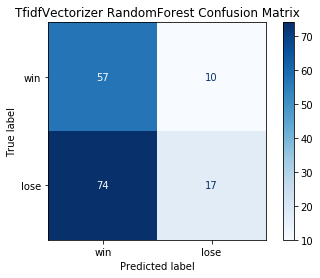

In [17]:
nb_cm = metrics.plot_confusion_matrix(rf,
                                       tfidf_test,
                                       y_test,
                                       display_labels=["win", "lose"],
                                       cmap=pyplot.cm.Blues)
pyplot.title('TfidfVectorizer RandomForest Confusion Matrix')

Text(0.5, 1.0, 'CountVectorizer RandomForest Confusion Matrix')

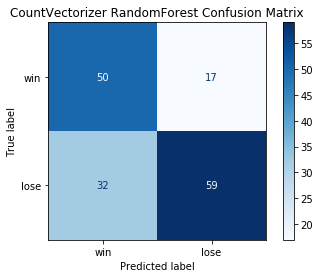

In [18]:
nb_cm = metrics.plot_confusion_matrix(rf,
                                       count_test,
                                       y_test,
                                       display_labels=["win", "lose"],
                                       cmap=pyplot.cm.Blues)
pyplot.title('CountVectorizer RandomForest Confusion Matrix')

## Linear SVC

In [19]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc_model = lsvc.fit(tfidf_train, y_train)
lsvc_predict = lsvc_model.predict(tfidf_test)
#lsvc_score = metrics.accuracy_score(lsvc_predict, y_test)
precision, recall, fscore, train_support = score(y_test, lsvc_predict, pos_label=1, average='binary')
print('tfidf : Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), 
                                                                 round(recall, 3), 
                                                                 round((lsvc_predict == y_test).sum()/len(lsvc_predict), 3)))

lsvc_model_count = lsvc.fit(count_train, y_train)
lsvc_predict_count = lsvc_model_count.predict(count_test)
lsvc_score_count = metrics.accuracy_score(lsvc_predict_count, y_test)

precision, recall, fscore, train_support = score(y_test, lsvc_predict_count, pos_label=1, average='binary')
print('count : Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), 
                                                                 round(recall, 3), 
                                                                 round((lsvc_predict_count == y_test).sum()/len(lsvc_predict_count), 3)))



tfidf : Precision: 0.688 / Recall: 0.725 / Accuracy: 0.652
count : Precision: 0.694 / Recall: 0.747 / Accuracy: 0.665


Text(0.5, 1.0, 'TfidfVectorizer Linear SVC Confusion Matrix')

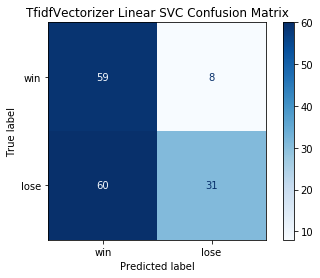

In [20]:
lsvc_cm = metrics.plot_confusion_matrix(lsvc,
                                       tfidf_test,
                                       y_test,
                                       display_labels=["win", "lose"],
                                       cmap=pyplot.cm.Blues)
pyplot.title('TfidfVectorizer Linear SVC Confusion Matrix')

Text(0.5, 1.0, 'CountVectorizer Linear SVC Confusion Matrix')

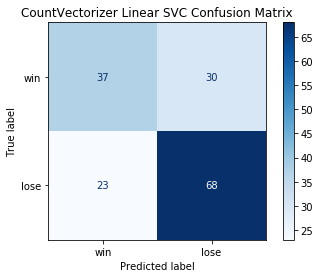

In [21]:
lsvc_cm = metrics.plot_confusion_matrix(lsvc,
                                       count_test,
                                       y_test,
                                       display_labels=["win", "lose"],
                                       cmap=pyplot.cm.Blues)

pyplot.title('CountVectorizer Linear SVC Confusion Matrix')

## Multinomial Naive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb_model = nb.fit(tfidf_train, y_train)
nb_predict = nb_model.predict(tfidf_test)
nb_score = metrics.accuracy_score(y_test, nb_predict)
precision, recall, fscore, train_support = score(y_test, nb_predict, pos_label=1, average='binary')
print('tfidf : Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), 
                                                                 round(recall, 3), 
                                                                 round((nb_predict == y_test).sum()/len(nb_predict), 3)))
nb_model_count = nb.fit(count_train, y_train)
nb_predict_count = nb_model_count.predict(count_test)
nb_score_count = metrics.accuracy_score(y_test, nb_predict_count)

precision, recall, fscore, train_support = score(y_test, nb_predict_count, pos_label=1, average='binary')
print('count : Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), 
                                                                 round(recall, 3), 
                                                                 round((nb_predict_count == y_test).sum()/len(nb_predict_count), 3)))



tfidf : Precision: 0.636 / Recall: 0.769 / Accuracy: 0.614
count : Precision: 0.667 / Recall: 0.747 / Accuracy: 0.639


Text(0.5, 1.0, 'TfidfVectorizer Multinomial Naive Bayes Confusion Matrix')

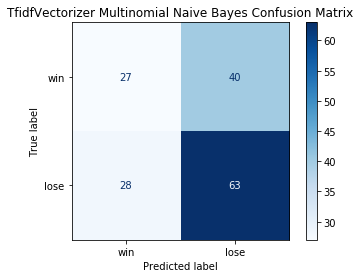

In [23]:
nb_cm = metrics.plot_confusion_matrix(nb,
                                       tfidf_test,
                                       y_test,
                                       display_labels=["win", "lose"],
                                       cmap=pyplot.cm.Blues)
pyplot.title('TfidfVectorizer Multinomial Naive Bayes Confusion Matrix')

Text(0.5, 1.0, 'CountVectorizer Multinomial Naive Bayes Confusion Matrix')

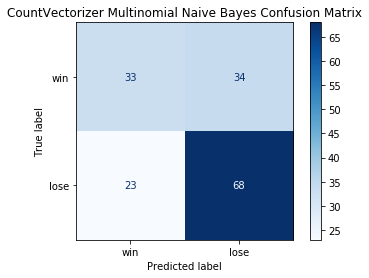

In [24]:
nb_cm_count = metrics.plot_confusion_matrix(nb,
                                       count_test,
                                       y_test,
                                       display_labels=["win", "lose"],
                                       cmap=pyplot.cm.Blues)
pyplot.title('CountVectorizer Multinomial Naive Bayes Confusion Matrix')

## Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_model = log_reg.fit(tfidf_train, y_train)
log_predict = log_model.predict(tfidf_test)
log_score = metrics.accuracy_score(y_test, log_predict)

precision, recall, fscore, train_support = score(y_test, log_predict, pos_label=1, average='binary')
print('tfidf : Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), 
                                                                 round(recall, 3), 
                                                                 round((log_predict == y_test).sum()/len(log_predict), 3)))

log_model_count = log_reg.fit(count_train, y_train)
log_predict_count = log_model_count.predict(count_test)
log_score_count = metrics.accuracy_score(y_test, log_predict_count)

precision, recall, fscore, train_support = score(y_test, log_predict_count, pos_label=1, average='binary')
print('count : Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), 
                                                                 round(recall, 3), 
                                                                 round((log_predict_count == y_test).sum()/len(log_predict_count), 3)))


tfidf : Precision: 0.7 / Recall: 0.769 / Accuracy: 0.677
count : Precision: 0.763 / Recall: 0.78 / Accuracy: 0.734


Text(0.5, 1.0, 'TfidfVectorizer Logistic Regression Confusion Matrix')

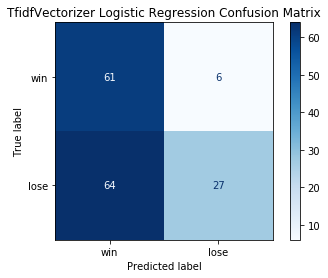

In [26]:
log_cm = metrics.plot_confusion_matrix(log_reg,
                                       tfidf_test,
                                       y_test,
                                       display_labels=["win", "lose"],
                                       cmap=pyplot.cm.Blues)
pyplot.title('TfidfVectorizer Logistic Regression Confusion Matrix')

Text(0.5, 1.0, 'CountVectorizer Logistic Regression Confusion Matrix')

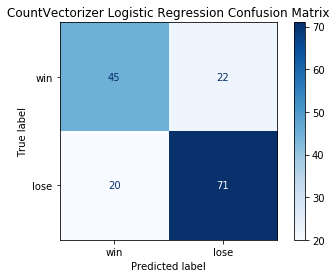

In [27]:
log_cm_count = metrics.plot_confusion_matrix(log_reg,
                                       count_test,
                                       y_test,
                                       display_labels=["win", "lose"],
                                       cmap=pyplot.cm.Blues)
pyplot.title('CountVectorizer Logistic Regression Confusion Matrix')

# Findings and next steps

- Classifiers using the TfidfVectorier seems to be biased towards a certain outcome. This is shown in the confusion matrices of RandomForest, Linear SVC and Logistic Regression where most of the predicted labels are emphasized on 'win'
- The Logistic Regression model using the CountVectorizer is found to have the best accuracy(73.4%) and recall(78%) for this dataset.
- For most classifiers using the CountVectorizer, 'lose' was predicted correctly a lot more than 'win'
- Feature engineering could be used to explore possible relations between certain words and the label